In [102]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

import re
from acquire import extract, build_extracted_df, get_new_patch_data, get_players
from prepare import prepare
from env import api_key

In [103]:
pd.set_option("display.max_rows", None, "display.max_columns", None) 

pd.reset_option("display.max_rows", "display.max_columns")

In [104]:
# Bring in DataFrame
df = pd.read_csv("final_10.csv")

# Split the data
train, test = prepare(df)

### columns to drop

In [105]:
to_drop=['gameEndTimestamp',
'gameId',
'gameMode',
'gameName',
'gameStartTimestamp',
'gameType',
'gameVersion',
'matchId',
'queueId',
'timestamp',
'time_cutoff',
'ward_player_0',
'riftherald_team300',
'gameDuration',
'Unnamed: 0']

In [106]:
train = train.drop(columns=to_drop)

In [107]:
test = test.drop(columns=to_drop)

In [108]:
train.shape, test.shape

((3890, 251), (973, 251))

In [109]:
columns_to_scale = list(train.drop(columns=['winningTeam']).columns)

In [83]:
# columns_to_scale

In [110]:
def add_scaled_columns(train, test, scaler, columns_to_scale):
    
    # new column names
    new_column_names = [c + '_scaled' for c in columns_to_scale]
    
    # Fit the scaler on the train
    scaler.fit(train[columns_to_scale])
    
    # transform train validate and test
    train = pd.concat([
        train,
        pd.DataFrame(scaler.transform(train[columns_to_scale]), columns=new_column_names, index=train.index),
    ], axis=1)
    
    train = train.drop(columns=columns_to_scale)
    
#     validate = pd.concat([
#         validate,
#         pd.DataFrame(scaler.transform(validate[columns_to_scale]), columns=new_column_names, index=validate.index),
#     ], axis=1)
    
    
    test = pd.concat([
        test,
        pd.DataFrame(scaler.transform(test[columns_to_scale]), columns=new_column_names, index=test.index),
    ], axis=1)
    
    test = test.drop(columns=columns_to_scale)
    
    return train, test

In [111]:
train_scaled, test_scaled = add_scaled_columns(train, test, MinMaxScaler(), columns_to_scale)

In [112]:
train_scaled.to_csv("final10_train_scaled.csv")

In [113]:
test_scaled.to_csv("final10_test_scaled.csv")

In [114]:
X_train = train_scaled.drop(columns="winningTeam")
y_train = train_scaled.winningTeam

X_test = test_scaled.drop(columns="winningTeam")
y_test = test_scaled.winningTeam

In [87]:
# sklearn implementation of KMeans

#define the thing
kmeans = KMeans(n_clusters=2, random_state=1349)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

array([0, 0, 0, ..., 1, 0, 0], dtype=int32)

In [88]:
# make a new column names cluster in iris and X_scaled dataframe
df = pd.DataFrame()
df['cluster'] = kmeans.predict(X_train)

X_train['cluster'] = kmeans.predict(X_train)

In [89]:
X_train['cluster'].value_counts()

0    2419
1    1471
Name: cluster, dtype: int64

In [90]:
kmeans.inertia_

21715.848960585226

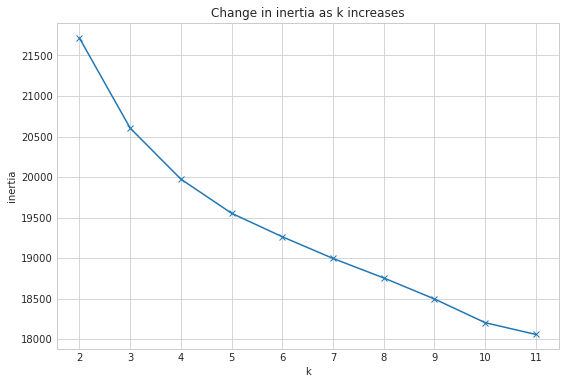

In [91]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_train).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [92]:
boolean_dummy = pd.get_dummies(X_train['cluster'], drop_first=False)
X_train = pd.concat([X_train, boolean_dummy], axis = 1)

In [93]:
X_train = X_train.rename(columns = {
            0:'cluster_0', 
            1:'cluster_1'})

In [94]:
X_train[['cluster_0', 'cluster_1']]

,cluster_0,cluster_1
3513,1,0
1250,1,0
3532,1,0
3858,0,1
528,0,1
...,...,...
1593,1,0
4060,0,1
1346,0,1
3454,1,0


In [95]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=4, 
                            random_state=123)

In [96]:
rf.fit(X_train[['cluster_0', 'cluster_1']], y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=2, random_state=123)

In [97]:
rf.score(X_train[['cluster_0', 'cluster_1']], y_train)

0.5516709511568123

In [99]:
results = cross_val_score(rf, X_train[['cluster_0', 'cluster_1']], y_train, cv=10)

In [100]:
results

array([0.56812339, 0.55269923, 0.5218509 , 0.59125964, 0.53984576,
       0.53984576, 0.57840617, 0.5218509 , 0.54241645, 0.56041131])

In [101]:
results.mean()

0.5516709511568123